Reference Links:<br>
https://fanpu.io/blog/2023/score-based-diffusion-models/<br>
https://mfkasim1.github.io/2022/07/04/sgm-2/


In [1]:
# 1 sample the training data from the swiss roll distribution.
# 2 From the training data, we will try to learn how to draw new samples from the swiss roll distribution with Score-based Generative Model (SGM)
# 3 with VE SDE

In [2]:
import torch
from sklearn.datasets import make_swiss_roll

# generate the swiss roll dataset
# generate 1000 samples and add Gaussion noise with a standard deviation of 1.0 to the data
xnp, _ = make_swiss_roll(1000, noise=0.1)
xtns = torch.as_tensor(xnp[:, [0, 2]] / 10.0, dtype=torch.float32)
dset = torch.utils.data.TensorDataset(xtns)
# creates a TensorDataset from the xtns tensor. This makes it easy batching and shuffling of the data.

In [3]:
len(xtns)

1000

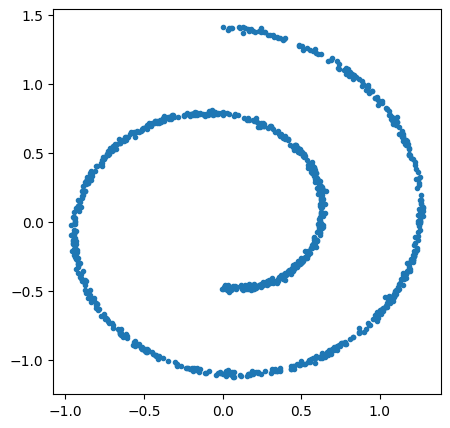

In [4]:
# show the samples
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(xtns[:, 0], xtns[:, 1], 'C0.')

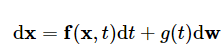

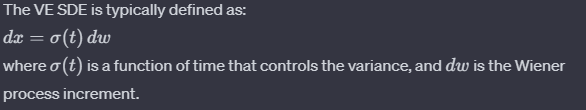

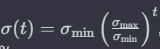

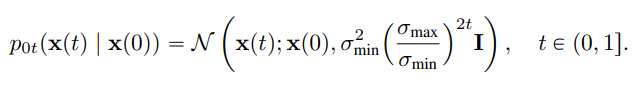

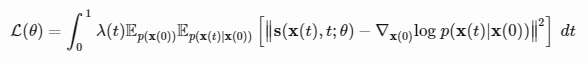
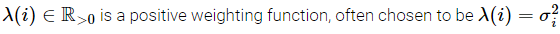

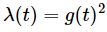

In [5]:
import numpy as np
def max_euclidean_distance(data):
    max_distance = 0
    n = len(data)
    for i in range(n):
        for j in range(i+1, n):
            distance = np.linalg.norm(data[i] - data[j])
            max_distance = max(max_distance, distance)
    return max_distance
swiss_data = xnp[:, [0, 2]] / 10.0
max_distance = max_euclidean_distance(swiss_data)
max_distance

2.5396641203531884

In [6]:
# score_network takes input of 2 + 1 (time) and returns the output of the same size (2)
score_network = torch.nn.Sequential(
    torch.nn.Linear(3, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)

In [7]:
import torch.nn as nn
class GaussianFourierTimeEncoding(nn.Module):
  def __init__(self, embedding_size=256, scale=1.0):
    super().__init__()
    self.W = nn.Parameter(torch.randn(embedding_size//2) * scale, requires_grad=False)

  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    emb = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
    return emb

def get_timestep_embedding(embedding_dim=32, embedding_scale=1000):
  emb_func = GaussianFourierTimeEncoding(embedding_size=embedding_dim, scale=embedding_scale)
  return emb_func

In [8]:
t = torch.rand((32, 1)) * (1 - 1e-4) + 1e-4

In [9]:
t.shape

torch.Size([32, 1])

In [10]:
get_timestep_embedding(embedding_dim=256)(t).squeeze(1)

tensor([[ 0.2308, -0.9546, -0.4299,  ..., -0.9990, -0.9685,  0.8773],
        [-0.0485, -0.9871,  0.8934,  ...,  0.2756,  0.9683,  0.9978],
        [-0.9629,  0.9962, -0.8516,  ...,  0.2847, -0.4157,  0.9737],
        ...,
        [-0.8837, -0.9826, -0.9771,  ..., -0.1666, -0.9598,  0.9260],
        [ 1.0000, -0.9182,  0.8005,  ...,  0.7606, -0.4838, -0.4919],
        [-0.3468, -0.9363,  0.9587,  ...,  0.5755,  0.0649, -0.9999]])

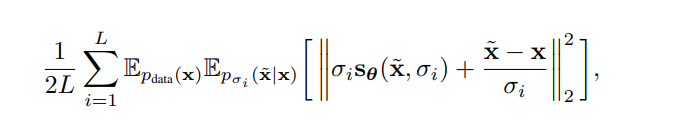

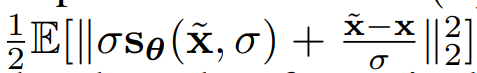

In [11]:
# define the loss function

def calc_loss(score_network: torch.nn.Module, x: torch.Tensor, sigma_min=0.01, sigma_max=2.6) -> torch.Tensor:

    # x: (batch_size, 2) is the training data

    # sample the time
    t = torch.rand((x.shape[0], 1), dtype=x.dtype, device=x.device) * (1 - 1e-4) + 1e-4

    # print(t.shape)  ==> torch.Size([256, 1])
    # print(t) ==> tensor([[0.5963],[0.5211],...,[0.4235]])

    # For VE SDE, the mean remains the same (no drift term) and variance increases over time
    sigma_t = sigma_min ** (1 - t) * sigma_max ** t  # Define sigma_min and sigma_max appropriately

    mu_t = x  # In VE, mean remains unchanged (batch_size, 2)
    var_t = sigma_t ** 2  # Variance increases over time (batch_size, 1)

    # torch.expm1(x) computes exp(x)-1. Therefore, -torch.expm1(-int_beta) calculates 1 - \exp(-\text{int_beta})
    x_t = torch.randn_like(x) * sigma_t + mu_t
    grad_log_p = -(x_t - mu_t) / sigma_t  # (batch_size, 2)



    # calculate the score function
    xt = torch.cat((x_t, sigma_t), dim=-1)  # (batch_size, 3)
    # print(x_t.shape)
    # print(time_emb.shape)
    # print(xt.shape)
    # torch.cat((x_t, t), dim=-1) is to concatenate x_t (batch_size,2) and t (batch_size,1) along the last dimension (features dimension).
    score = score_network(xt)  # score: (batch_size, 2)

    # calculate the loss function
    loss = 0.5 * (sigma_t * score - grad_log_p) ** 2
    # lmbda_t = var_t
    # weighted_loss = lmbda_t * loss
    # print(loss.shape)
    # print(loss)
    # print(torch.mean(loss))
    return torch.mean(loss)
    # torch.mean is used to approximate the continuous integral in the loss function by averaging the loss over both the data samples in a batch and the discrete time steps.

In [22]:
# start the training loop
import time
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(dset, batch_size=256, shuffle=True)
t0 = time.time()
for i_epoch in range(50000):
    total_loss = 0
    for data, in dloader:
        opt.zero_grad()

        # training step
        loss = calc_loss(score_network.to('cpu'), data.to('cpu'))
        loss.backward()
        opt.step()

        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 5000 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")

0 (0.04718208312988281s): 0.3750702953338623
5000 (104.19833898544312s): 0.3347734847068787
10000 (236.16540598869324s): 0.2860120792388916
15000 (381.11927676200867s): 0.27833293223381045
20000 (530.3519797325134s): 0.2818694272041321
25000 (685.5261046886444s): 0.295689450263977
30000 (843.5061905384064s): 0.26635754549503327
35000 (1003.7721390724182s): 0.2941543972492218
40000 (1165.3475358486176s): 0.2522073986530304
45000 (1328.1632220745087s): 0.24841950774192811


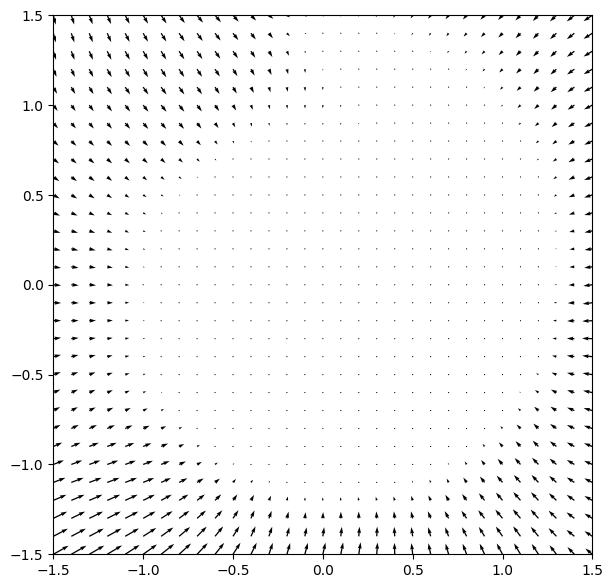

In [23]:
# display the Score function (the vector field) in the 2D space
import matplotlib.pyplot as plt

# Generate grid of input points
res = 0.1
x = torch.arange(-2, 2, res)
y = torch.arange(-2, 2, res)
xx, yy = torch.meshgrid(x, y)
x_grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# Set a specific time step (e.g., t = 0)
t = torch.full((x_grid.shape[0], 1), 0)
sigma_t = 0.01 ** (1 - t) * 2.6 ** t
# Concatenate the grid points with the time step
xt_grid = torch.cat((x_grid, sigma_t), dim=1)

# Get score vectors on the grid at the specified time step
s_grid = score_network(xt_grid).detach()

# Plot with adjusted size and axis range
fig, ax = plt.subplots(figsize=(7, 7))  # Set the figure size
ax.quiver(x_grid[:, 0], x_grid[:, 1], s_grid[:, 0], s_grid[:, 1])
ax.set_aspect('equal')
ax.set_xlim(-1.5, 1.5)  # Set x-axis range
ax.set_ylim(-1.5, 1.5)  # Set y-axis range
plt.show()

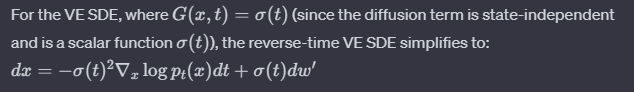

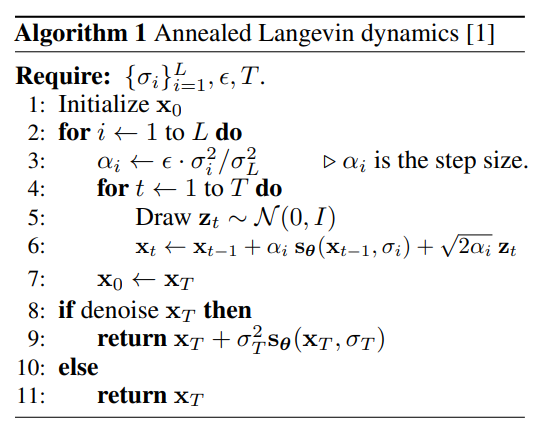

In [24]:
def generate_samples(score_network: torch.nn.Module, nsamples: int, step_size=1e-4, sigma_min=0.01, sigma_max=2.6) -> torch.Tensor:
    x_t = torch.randn((nsamples, 2))  # (nsamples, 2)
    time_pts = torch.linspace(1, 0, 100)  # (ntime_pts,)
    saved_samples = []

    for i in range(0, len(time_pts)):
        t = time_pts[i]

        sigma_t = sigma_min * (sigma_max / sigma_min) ** t
        alpha = step_size * (sigma_t / sigma_min) ** 2

        z_t = torch.randn_like(x_t)

        score = score_network(torch.cat((x_t, sigma_t.expand(x_t.shape[0], 1)), dim=-1)).detach()

        x_t = x_t + alpha * score + (2 * alpha) ** 0.5 * z_t


        # Save samples every 10 steps
        if (i+2) % 10 == 0:
            saved_samples.append(x_t.clone())
    return saved_samples

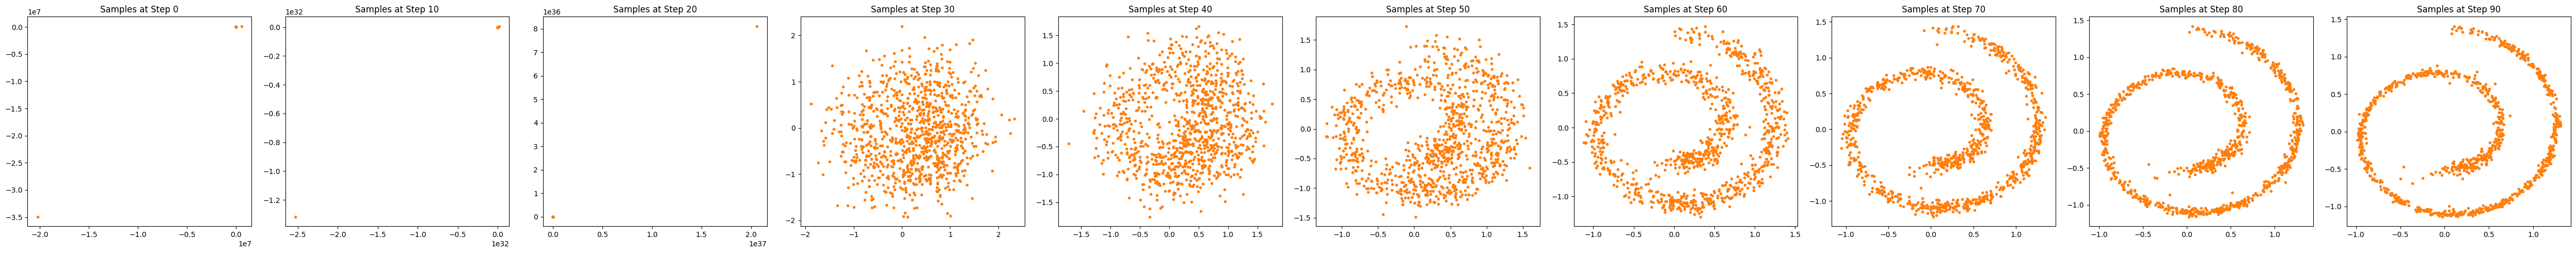

In [25]:
# generate 1000 samples every 10 timesteps (old method)
saved_samples = generate_samples(score_network, 1000)

num_plots = len(saved_samples)
fig, axs = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))

for idx, samples in enumerate(saved_samples):
    axs[idx].plot(samples[:, 0], samples[:, 1], 'C1.')
    axs[idx].set_title(f"Samples at Step {idx * 10}")

fig.tight_layout()
plt.show()

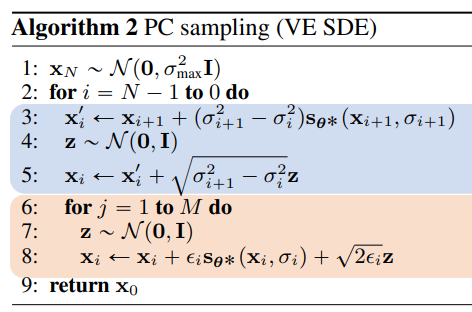

In [35]:
# Applying Predictor-Corrector (PC) samplers

def generate_PC_samples(score_network: torch.nn.Module, nsamples: int, num_corrector_steps=10, step_size=1e-2, sigma_min=0.01, sigma_max=2.6) -> torch.Tensor:
    x_t = torch.randn((nsamples, 2))  # (nsamples, 2)
    time_pts = torch.linspace(1, 0, 100)  # (ntime_pts,)
    saved_samples = []

    for i in range(0, len(time_pts)-1):
        t_i_plus_1 = time_pts[i]
        t_i = time_pts[i + 1]

        # Predictor step (same as before)
        sigma_i_plus_1 = sigma_min * (sigma_max / sigma_min) ** t_i_plus_1
        sigma_i = sigma_min * (sigma_max / sigma_min) ** t_i

        z = torch.rand_like(x_t)

        score = score_network(torch.cat((x_t, sigma_i_plus_1.expand(x_t.shape[0], 1)), dim=-1)).detach()

        x_i_bar = x_t + (sigma_i_plus_1 ** 2 - sigma_i ** 2) * score

        x_i = x_i_bar + torch.sqrt(sigma_i_plus_1 ** 2 - sigma_i ** 2) * z


        # Corrector step (Langevin Dynamics)
        for _ in range(num_corrector_steps):
            grad_score = score_network(torch.cat((x_i, sigma_i.expand(x_i.shape[0], 1)), dim=-1)).detach()
            x_i = x_i + step_size * grad_score + torch.sqrt(torch.tensor(2 * step_size)) * torch.randn_like(x_i)

        # Save samples every 10 steps
        if (i+2) % 10 == 0:
            saved_samples.append(x_i.clone())
    return saved_samples

Default Corrector Steps: 10

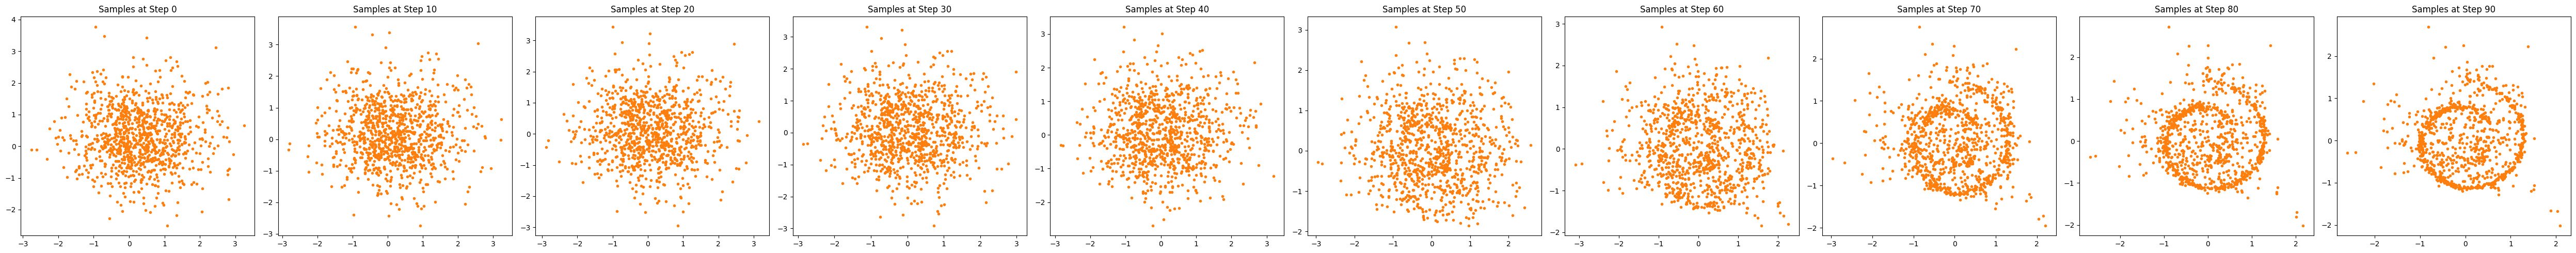

In [27]:
saved_samples = generate_PC_samples(score_network, 1000, step_size=1e-4)

num_plots = len(saved_samples)
fig, axs = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))

for idx, samples in enumerate(saved_samples):
    axs[idx].plot(samples[:, 0], samples[:, 1], 'C1.')
    axs[idx].set_title(f"Samples at Step {idx * 10}")

fig.tight_layout()
plt.show()

Corrector Steps: 20

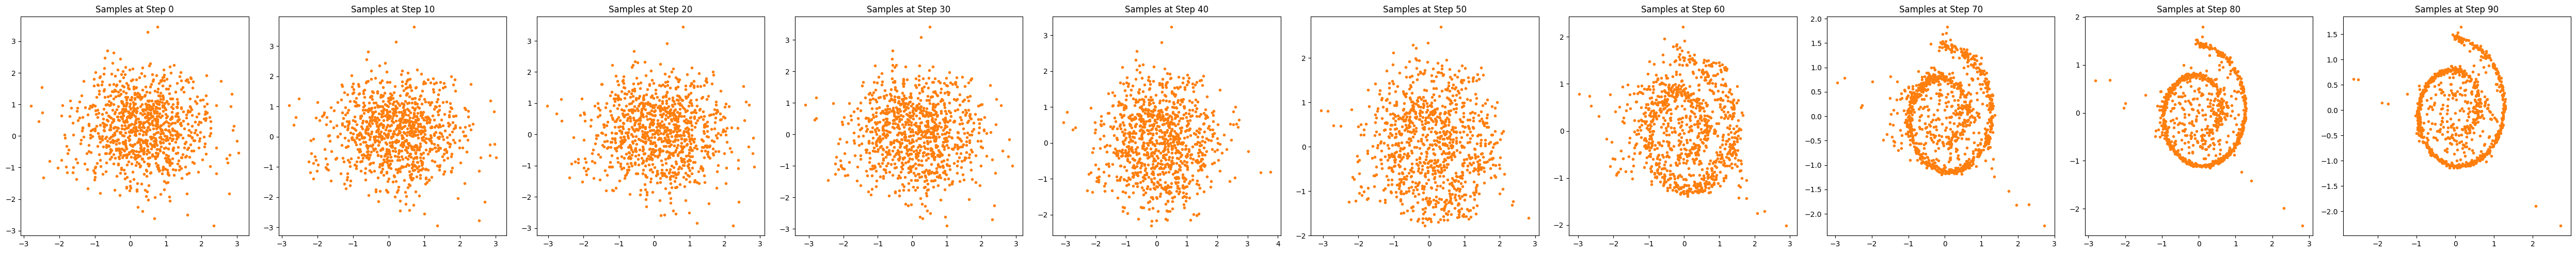

In [28]:
saved_samples = generate_PC_samples(score_network, 1000, step_size=1e-4, num_corrector_steps=20)

num_plots = len(saved_samples)
fig, axs = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))

for idx, samples in enumerate(saved_samples):
    axs[idx].plot(samples[:, 0], samples[:, 1], 'C1.')
    axs[idx].set_title(f"Samples at Step {idx * 10}")

fig.tight_layout()
plt.show()

Corrector Steps: 30

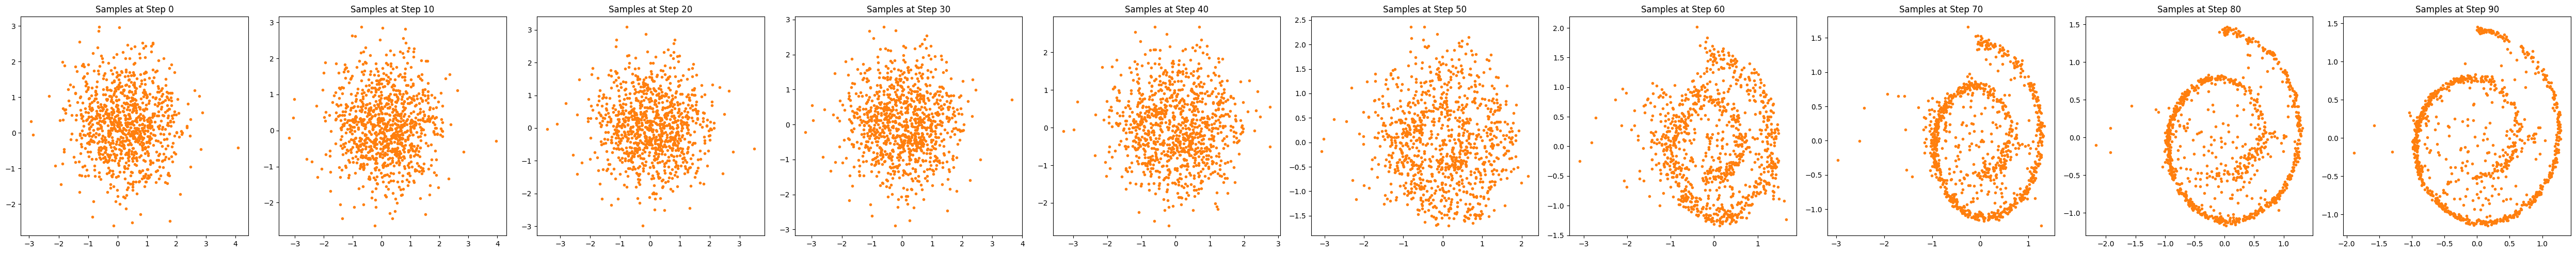

In [29]:
saved_samples = generate_PC_samples(score_network, 1000, step_size=1e-4, num_corrector_steps=30)

num_plots = len(saved_samples)
fig, axs = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))

for idx, samples in enumerate(saved_samples):
    axs[idx].plot(samples[:, 0], samples[:, 1], 'C1.')
    axs[idx].set_title(f"Samples at Step {idx * 10}")

fig.tight_layout()
plt.show()

Corrector Steps: 50

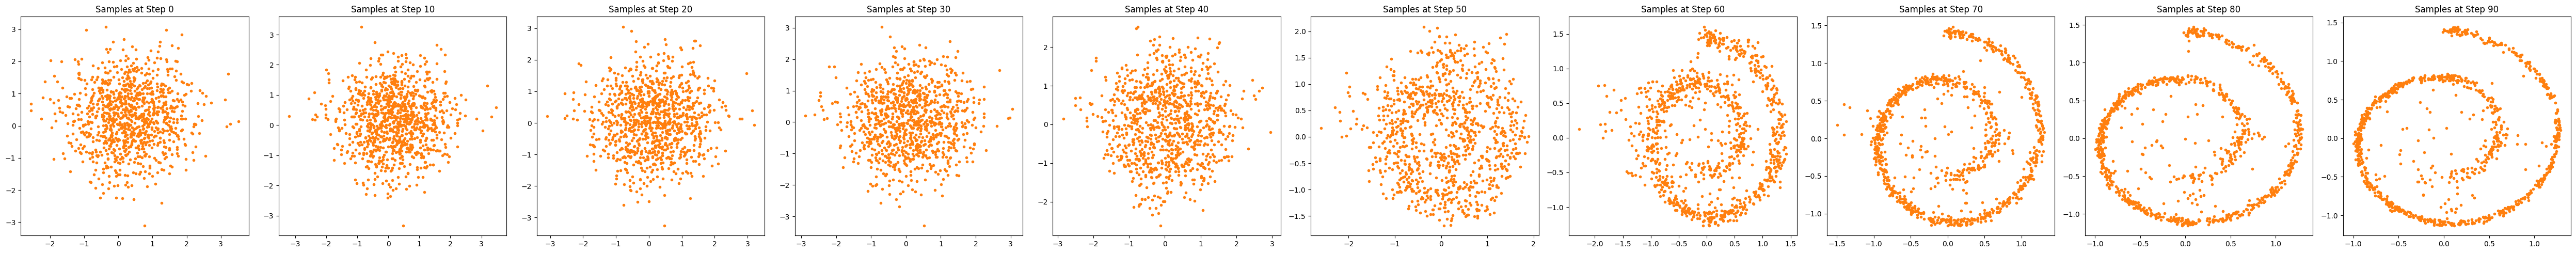

In [30]:
saved_samples = generate_PC_samples(score_network, 1000, step_size=1e-4, num_corrector_steps=50)

num_plots = len(saved_samples)
fig, axs = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))

for idx, samples in enumerate(saved_samples):
    axs[idx].plot(samples[:, 0], samples[:, 1], 'C1.')
    axs[idx].set_title(f"Samples at Step {idx * 10}")

fig.tight_layout()
plt.show()

Corrector Steps: 60

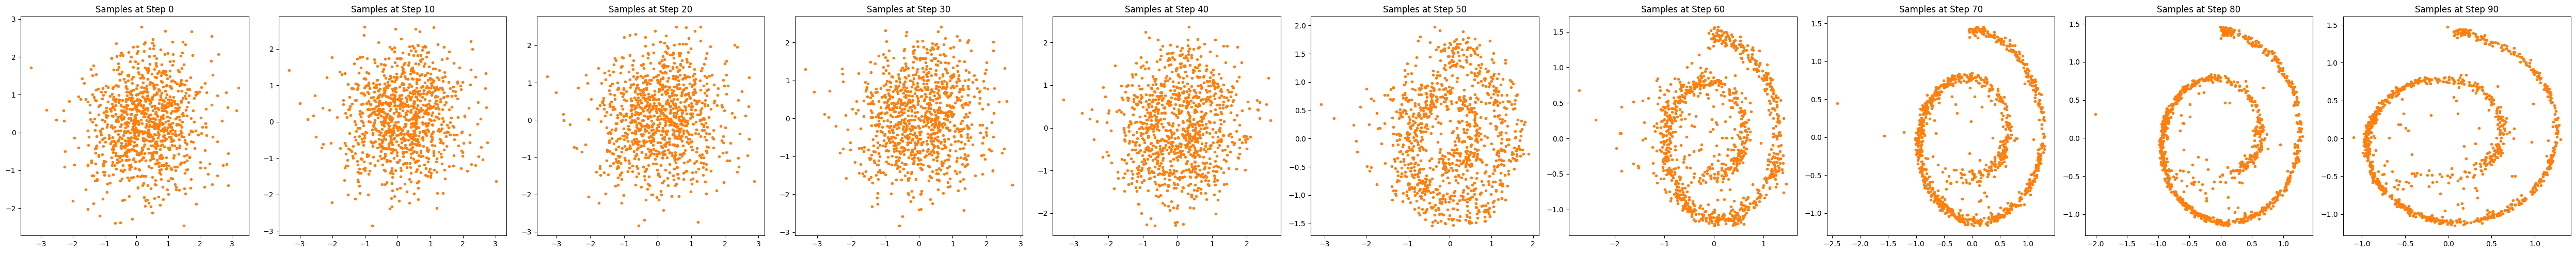

In [31]:
saved_samples = generate_PC_samples(score_network, 1000, step_size=1e-4, num_corrector_steps=60)

num_plots = len(saved_samples)
fig, axs = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))

for idx, samples in enumerate(saved_samples):
    axs[idx].plot(samples[:, 0], samples[:, 1], 'C1.')
    axs[idx].set_title(f"Samples at Step {idx * 10}")

fig.tight_layout()
plt.show()

Corrector Steps: 100

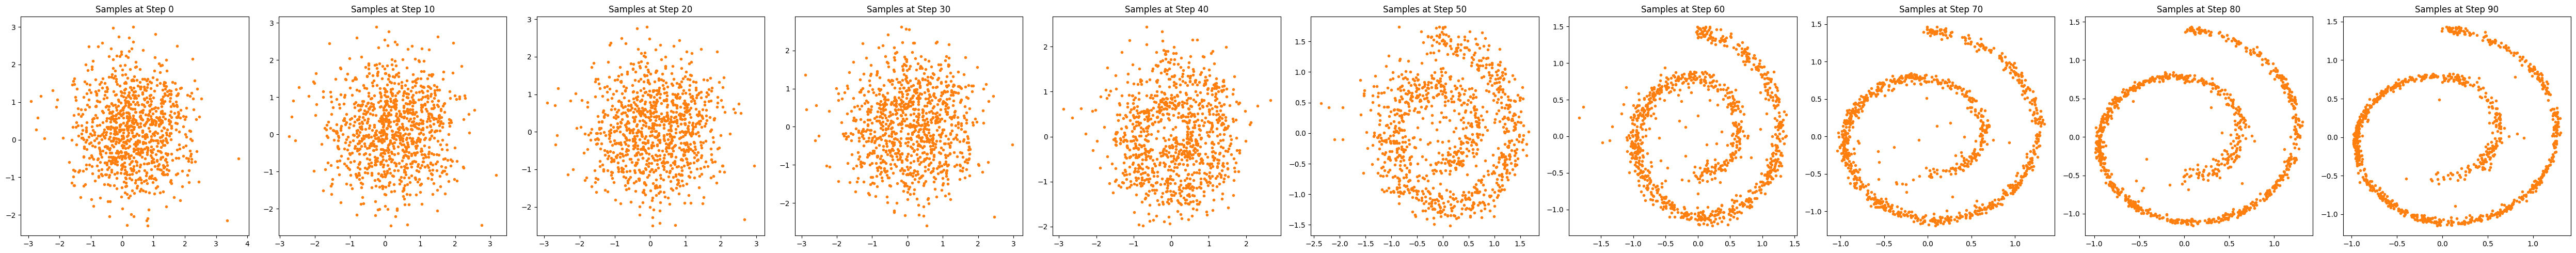

In [32]:
saved_samples = generate_PC_samples(score_network, 1000, step_size=1e-4, num_corrector_steps=100)

num_plots = len(saved_samples)
fig, axs = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))

for idx, samples in enumerate(saved_samples):
    axs[idx].plot(samples[:, 0], samples[:, 1], 'C1.')
    axs[idx].set_title(f"Samples at Step {idx * 10}")

fig.tight_layout()
plt.show()

Corrector Steps: 150

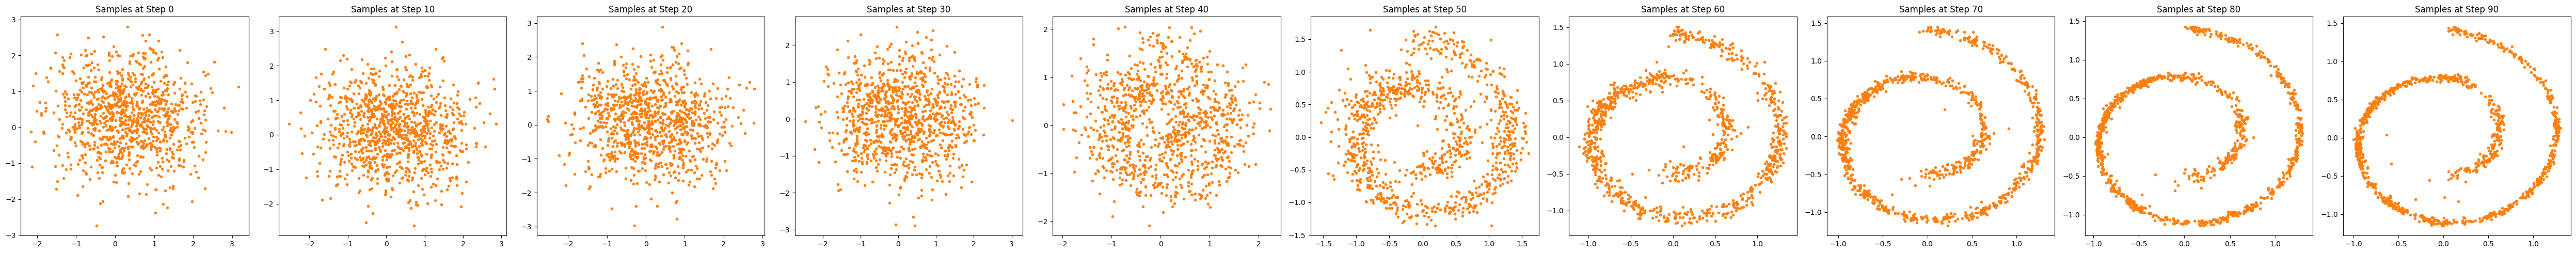

In [33]:
saved_samples = generate_PC_samples(score_network, 1000, step_size=1e-4, num_corrector_steps=150)

num_plots = len(saved_samples)
fig, axs = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))

for idx, samples in enumerate(saved_samples):
    axs[idx].plot(samples[:, 0], samples[:, 1], 'C1.')
    axs[idx].set_title(f"Samples at Step {idx * 10}")

fig.tight_layout()
plt.show()

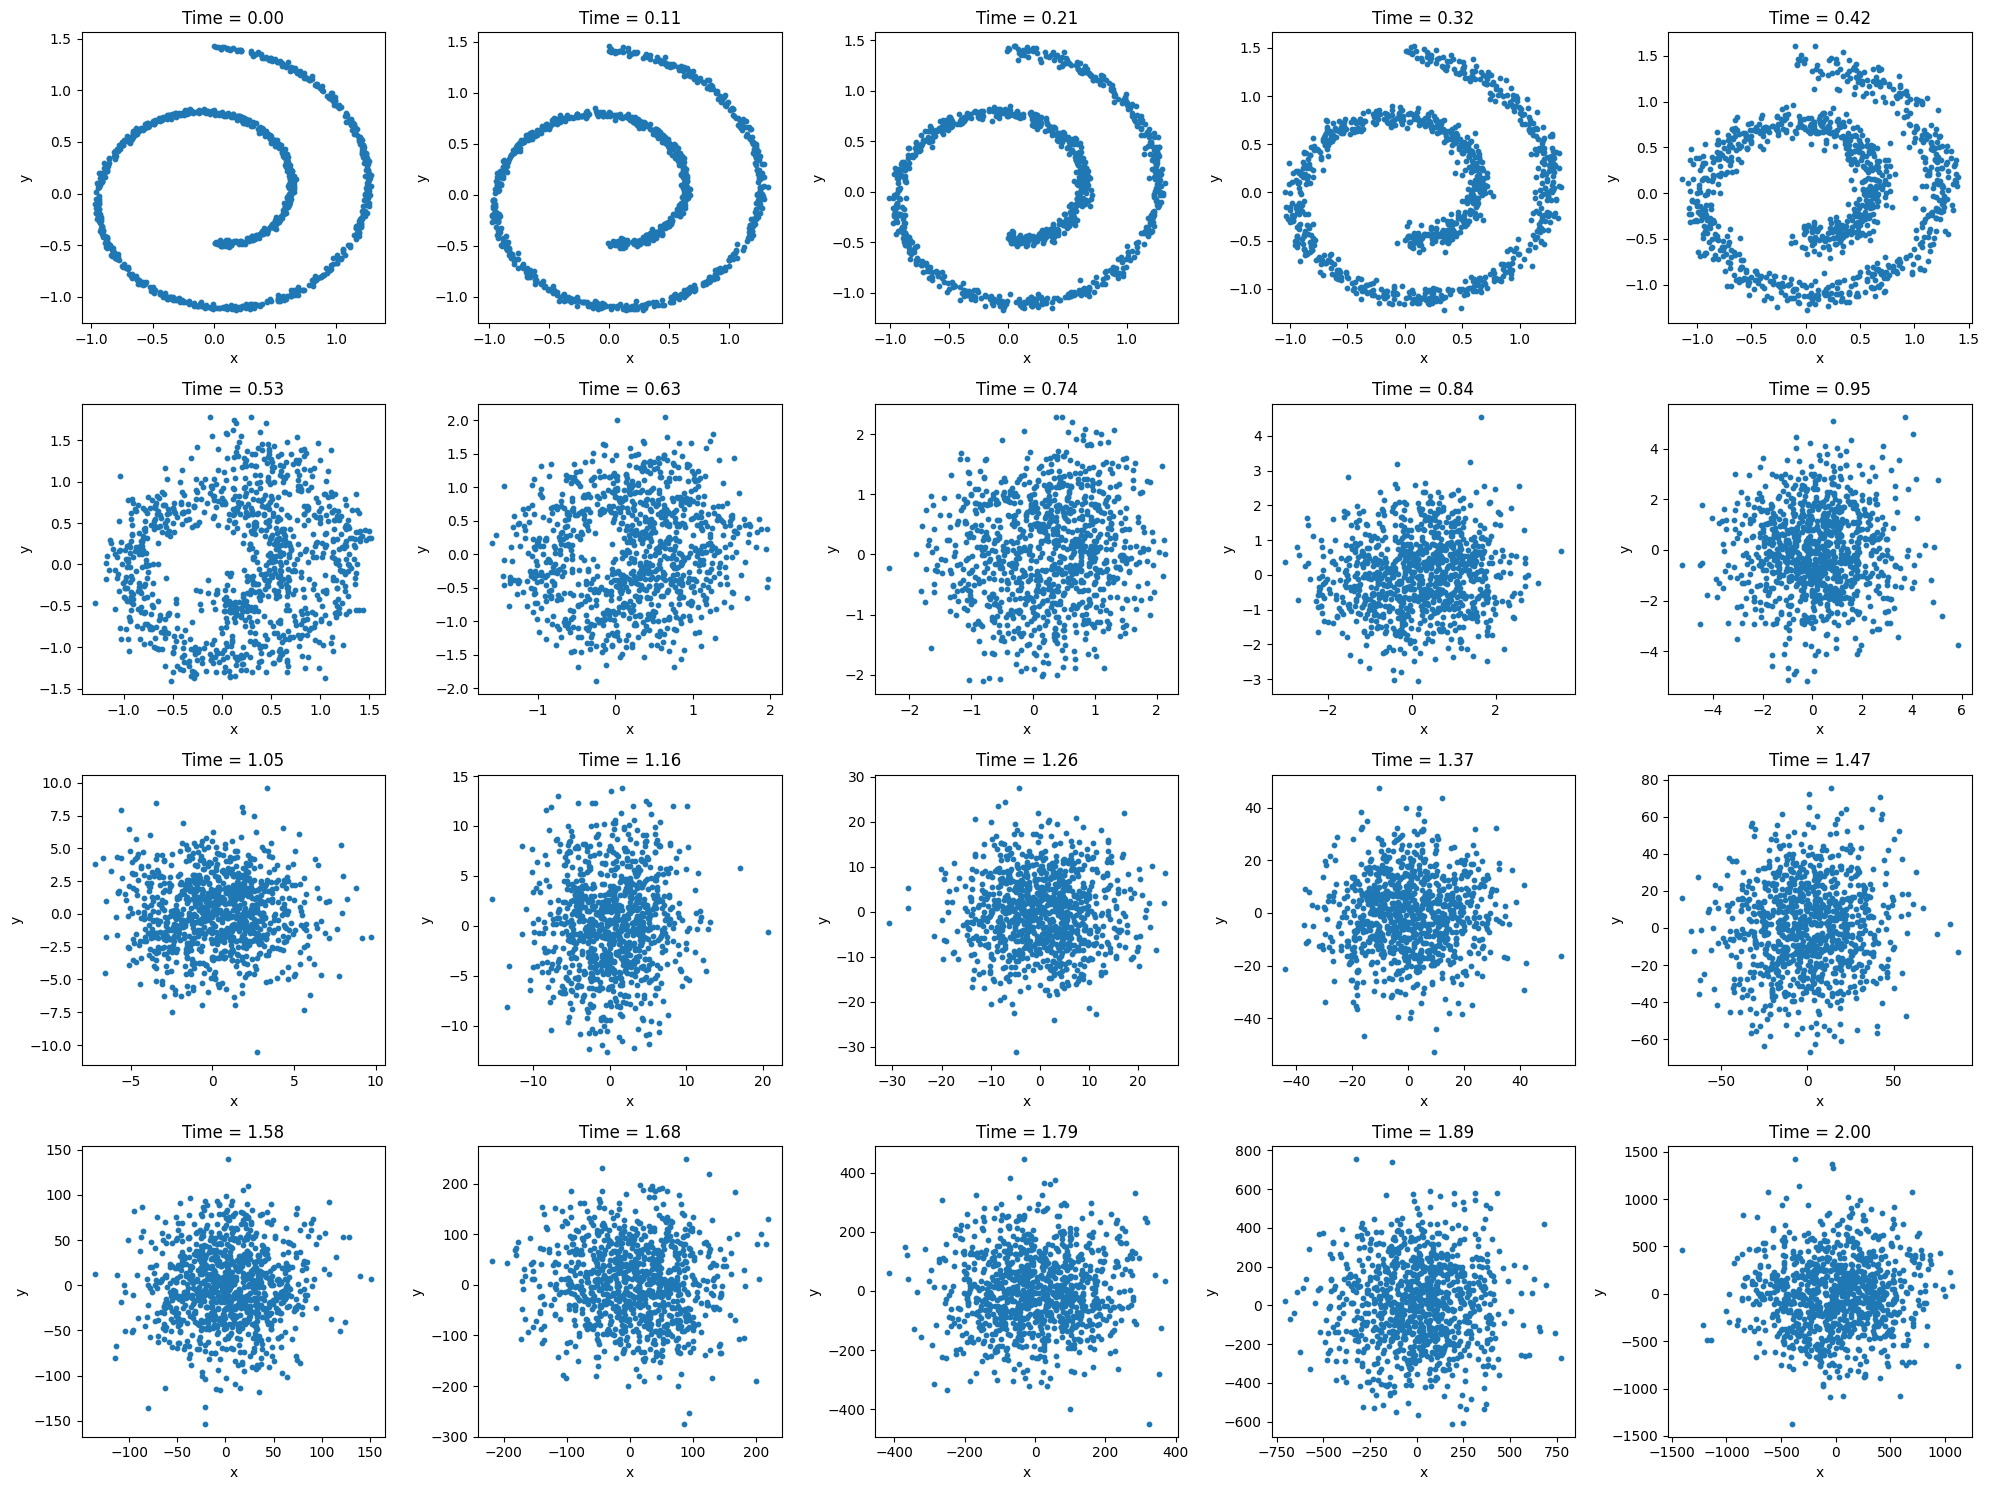

In [34]:
#@title Forward diffusion intermediate steps
import matplotlib.pyplot as plt
import numpy as np

def add_noise_to_data(x: torch.Tensor, time: float, sigma_min=0.01, sigma_max=2.0) -> torch.Tensor:
    """ Adds noise to data based on the specified time """
    sigma_t = sigma_min * (sigma_max / sigma_min) ** time
    var_t = sigma_t ** 2
    x_noisy = torch.randn_like(x) * var_t ** 0.5 + x
    return x_noisy

# Generate data
xnp, _ = make_swiss_roll(1000, noise=.1)
x = torch.as_tensor(xnp[:, [0, 2]] / 10.0, dtype=torch.float32)

# Time steps
time_steps = np.linspace(0, 2, 20) # 20 time steps from 0 to 1

# Plotting
plt.figure(figsize=(20, 15))
for i, time in enumerate(time_steps):
    x_noisy = add_noise_to_data(x, time)
    plt.subplot(4, 5, i+1)
    plt.scatter(x_noisy[:, 0].numpy(), x_noisy[:, 1].numpy(), s=10)
    plt.title(f"Time = {time:.2f}")
    plt.xlabel("x")
    plt.ylabel("y")

plt.tight_layout()
plt.show()
